In [1]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

# For Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# For Noise Simulations
from qiskit.test.mock import FakeMelbourne
fake_device = FakeMelbourne()

from qiskit.providers.aer.noise import NoiseModel

# Function for Finding Metrics

In [23]:
def metrics(counts):
    success, fail = 0, 0
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0 

    for result in counts:
        # checking if a result is a success or a failure
        check = 1
        for i in range(0, n-1):
            if (result[2*i] != result[2*i+1]):
                check=0
                break
                
        if (check == 1):
            success += counts[result]

            if (result[-1]=='0' and result[-2]=='0'): 
                phi_plus += counts[result]
            elif (result[-1]=='0' and result[-2]=='1'): 
                psi_plus += counts[result]
            elif (result[-1]=='1' and result[-2]=='0'): 
                phi_minus += counts[result]
            elif (result[-1]=='1' and result[-2]=='1'): 
                psi_minus += counts[result]
        else:
            fail += counts[result]

    total = success + fail
    print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
    yields = success/(total)
    print('yield:', yields, '\n')

    print('Among success, phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/success
    print('fidelity', fidelity)

# Build Circuit for Entanglement Purification

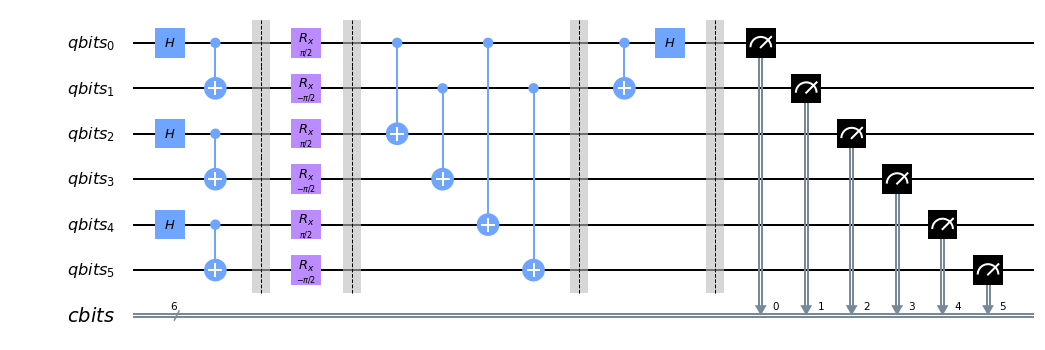

In [2]:
# number of qubits in purification
n = 3

qbits = QuantumRegister(2*n, 'qbits')
cbits = ClassicalRegister(2*n, 'cbits')

sys = QuantumCircuit(qbits, cbits)

# preparing bell-states
for i in range (0, 2*n, 2):
    sys.h(qbits[i])
    sys.cx(qbits[i], qbits[i+1])

sys.barrier()

# Deutsch's Correction
for i in range(0, n):
    sys.rx(pi/2, qbits[2*i])
    sys.rx(-pi/2, qbits[2*i+1])

sys.barrier()

# Bennett's Protocol 
for i in range(1, n):
    sys.cx(qbits[0], qbits[2*i])
    sys.cx(qbits[1], qbits[2*i+1])
    
sys.barrier()

# bell-basis measurement to check fidelity
sys.cx(qbits[0], qbits[1])
sys.h(qbits[0])

sys.barrier()

sys.measure(qbits, cbits)

sys.draw(output='mpl')

# Running on Real Device

In [22]:
job = execute(sys, 
              backend=device, shots=8192, optimization_level=0)

print(job.job_id())
job_monitor(job)

5ef1f8f1c745360013872b0e
Job Status: job has successfully run


In [24]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

metrics(device_counts)

{'010010': 119, '001111': 41, '010110': 101, '010101': 172, '000000': 717, '110000': 242, '100001': 209, '100010': 62, '100110': 57, '101101': 113, '011101': 157, '101110': 26, '010001': 427, '110011': 55, '100011': 72, '000010': 109, '000101': 276, '111111': 14, '011100': 245, '001000': 147, '110111': 44, '100111': 41, '000011': 115, '110100': 137, '111010': 21, '101001': 50, '001010': 48, '001110': 48, '110010': 63, '101111': 32, '000111': 67, '010111': 62, '000110': 74, '100100': 122, '001011': 33, '101010': 31, '000001': 370, '101000': 41, '111110': 21, '000100': 276, '010000': 341, '010100': 202, '011110': 45, '010011': 88, '011001': 71, '110001': 309, '001001': 105, '001101': 345, '111001': 61, '011000': 100, '111101': 157, '111000': 64, '110101': 126, '100000': 205, '011010': 46, '100101': 104, '001100': 286, '111011': 18, '111100': 171, '011111': 65, '101100': 131, '110110': 43, '101011': 18, '011011': 34}
success: 3063 , fail: 5129 , total: 8192
yield: 0.3739013671875 

Among 

# Error Mitigation

In [25]:
#generating calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr=sys.qregs[0],
                                               circlabel='measurement_calibration')

# running calibration circuits
cal_job = execute(cal_circuits, 
                  backend=device, shots=8192, optimization_level=0)

print(cal_job.job_id())
job_monitor(cal_job)

5ef1f9da13b5f900139e9bea
Job Status: job has successfully run


In [26]:
cal_results = cal_job.result()

# creating mitigation filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

In [27]:
# error mitigation
mitigated_result = meas_filter.apply(device_result)
mitigated_counts = mitigated_result.get_counts(0)

print(mitigated_counts)

metrics(mitigated_counts)

{'101101': 102.32225840064739, '101000': 17.182706409159856, '001100': 239.52967886615284, '010100': 206.36767001417513, '111110': 17.613661471751545, '110001': 488.9882915038814, '000111': 41.425157473676826, '011110': 38.10899622523292, '000001': 233.3719616265191, '001110': 26.660042667593665, '110000': 341.50122534406535, '000000': 647.6723073716045, '110110': 57.45073711989089, '110010': 72.95046480248924, '101100': 115.4239372646653, '000101': 236.7319386968656, '010111': 61.01305423113847, '110101': 195.10535841258258, '000010': 30.365151587711466, '001111': 0.7316577123491581, '100111': 35.04907500240478, '111010': 26.14182985924599, '011011': 34.91572253295988, '101110': 21.325507832586567, '000011': 77.99459694848447, '010001': 484.1068935552985, '111100': 301.79105656969926, '011010': 47.921697885029154, '110111': 68.4130802845696, '101011': 13.955394579673744, '111001': 79.89047596082881, '111011': 24.548606931681363, '011000': 91.85416863408783, '110100': 194.4719140521676

# Noisy Simulation

In [43]:
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [44]:
noise_job = execute(sys, backend=simulator, shots=8192, optimization_level=0,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)

207d00a1-5c3f-4a39-bb66-353eb7c76771
Job Status: job has successfully run


In [45]:
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts)

{'00010010': 7, '01010110': 6, '01110010': 6, '10010011': 2, '10100000': 12, '10100100': 1, '11001000': 43, '00010110': 4, '01000010': 7, '00010101': 8, '10001100': 84, '10110000': 90, '10110001': 17, '11001111': 8, '00110000': 544, '11000000': 567, '11110000': 560, '11001010': 5, '11111101': 75, '10111011': 2, '11111010': 1, '11000011': 9, '00011101': 10, '00101110': 2, '10101000': 1, '11001110': 37, '10011111': 2, '00010001': 17, '00110011': 4, '01100100': 3, '00100011': 2, '01001101': 23, '10000010': 3, '00000101': 13, '11010101': 1, '10000000': 76, '10100111': 15, '00001000': 48, '11110110': 1, '10011100': 9, '11100011': 2, '01101010': 9, '01010001': 4, '11010000': 96, '10111010': 2, '00100111': 2, '00000011': 3, '00110100': 61, '11001101': 65, '11101110': 6, '00111010': 2, '01010101': 1, '11100111': 2, '00001010': 2, '00001110': 29, '01001001': 2, '11000001': 86, '00110010': 36, '11100101': 1, '11100110': 1, '10111111': 3, '00100100': 8, '00001011': 1, '10101100': 15, '10101101': 

In [40]:
test_counts = {'1111': 35, '0010': 211, '1011': 53, '0101': 88, '0001': 349, '1000': 289, '0000': 3048, '0100': 292, '0011': 29, '1100': 2980, '1001': 92, '1010': 56, '1101': 372, '1110': 194, '0111': 60, '0110': 44}

In [41]:
metrics(test_counts)

success: 7218 , fail: 974 , total: 8192
yield: 0.881103515625 

Among success, phi+: 6028 , psi+: 405 , phi-: 721 , psi-: 64
fidelity 0.8351343862565808


In [33]:
print(test_counts)

{'1111': 119, '0010': 136, '1011': 97, '0101': 204, '0001': 816, '1000': 222, '0000': 2470, '0100': 366, '0011': 232, '1100': 1894, '1001': 180, '1010': 133, '1101': 988, '1110': 112, '0111': 102, '0110': 121}
